In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
RANDOM_SEED = 69
BATCH_SIZE  = 32
EPOCHS      = 30
IMAGE_SIZE  = (224, 224)
LABEL_MODE  = "categorical"
AUGMENTATION_FACTOR = 0.2
TRAIN_DIR   = "dataset_splitted/train"
TEST_DIR    = "dataset_splitted/val"
TAGS = [
    "animal", "car", "cloud", "dance", "fire", "flower", "food", "sunset", "water"
]

In [3]:
print("training data 🧠:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    image_size=IMAGE_SIZE,
    seed=RANDOM_SEED,
    shuffle=True
)

print("test data 🧪:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    image_size=IMAGE_SIZE,
    seed=RANDOM_SEED,
    shuffle=False
)

training data 🧠:
Found 4481 files belonging to 9 classes.
test data 🧪:
Found 1122 files belonging to 9 classes.


In [5]:
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax


augmentaion_layer = Sequential([
    RandomFlip("horizontal", seed=RANDOM_SEED),
    RandomRotation(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomZoom(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomHeight(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomWidth(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    Rescaling(1/255.)
])
augmentaion_layer
base_model = tf.keras.applications.ResNet50V2(
                include_top=False, 
                weights=f"{os.getcwd()}/checkpoints/vitya_weights"
            )

base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = augmentaion_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
output_layer = Dense(len(TAGS), activation=softmax, name="output_layer")(x)

model = tf.keras.Model(input_layer, output_layer)
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

1/1 [==============================] - 1s 1s/step
[[1.4720793e-04 8.1386277e-03 7.5249867e-05 1.3448109e-01 3.2785098e-05
  9.5139212e-06 8.4878623e-01 1.0437242e-03 7.2854687e-03]]


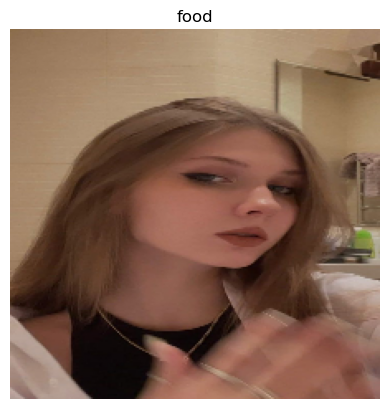

In [6]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img / 255.
    else:
        return img

image = load_and_prep_image("test.jpg", scale=False)
img = cv2.cvtColor(cv2.resize(cv2.imread("test.jpg"), (224, 224)), cv2.COLOR_RGB2BGR)
image = np.asarray(img)
image_expanded = tf.expand_dims(image, axis=0)
pred_prob = model.predict(image_expanded)
plt.imshow(image / 255)
plt.title(TAGS[pred_prob.argmax()])
plt.axis(False)
print(pred_prob)